In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-1c3b12fd-da17-8ebf-fb47-ea235e676e98)


In [ ]:

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
#from tensorflow.keras.models import Model
#from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau,ModelCheckpoint, TerminateOnNaN, EarlyStopping, TensorBoard,CSVLogger
import datetime
import os
from tensorflow.keras import backend as K
#from tensorflow.keras.models import load_model, save_model
#from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
import keras
from keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img

import pandas as pd
import numpy as np
import glob
import os
import cv2
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import *
#import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from datetime import *
import datetime
import pickle

In [ ]:
train_data_f = pickle.load(open('/content/gdrive/MyDrive/cs2/data/train_data_f.pkl', 'rb'))
train_data_f.head(3)

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,year,month,month_day,yr_day,week_day,week_no,lux_seg,med_seg,budget_seg,age_of_insur,cmpny_count,range_of_coverage,insuran_pd,low_expire,med_expire,hig_expire,cost_grt_20k,Condition,Amount
0,img_4513976.jpg,BQ,41500.0,1037.5,2026-12-03,36142.68,2026,12,3,337,3,49,0,1,0,5.23,131,35105.18,1,0,0,1,1,0,0.0
1,img_7764995.jpg,BQ,50700.0,1267.5,2025-07-10,12753.00,2025,7,10,191,3,28,1,0,0,3.83,131,11485.50,1,0,1,0,0,1,6194.0
2,img_451308.jpg,A,49500.0,1237.5,2022-08-11,43102.68,2022,8,11,223,3,32,1,0,0,0.91,132,41865.18,0,1,0,0,1,0,0.0


In [ ]:
x = train_data_f['Image_path']
y = train_data_f['Condition']

train,  cv = train_test_split(train_data_f, test_size = 0.35, random_state = 0)

print(f"train set shape: {train.shape}")
print(f"validation set shape: {cv.shape}")

train set shape: (909, 25)
validation set shape: (490, 25)


In [ ]:
train['Condition'].value_counts()

1    847
0     62
Name: Condition, dtype: int64

In [ ]:
cv['Condition'].value_counts()

1    453
0     37
Name: Condition, dtype: int64

In [ ]:
test_data_f = pickle.load(open('/content/gdrive/MyDrive/cs2/data/test_data_f.pkl', 'rb'))
test_data_f.head(3)

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,year,month,month_day,yr_day,week_day,week_no,lux_seg,med_seg,budget_seg,age_of_insur,cmpny_count,range_of_coverage,insuran_pd,low_expire,med_expire,hig_expire,cost_grt_20k
0,img_4538519.jpg,B,23600,590.0,2025-04-12,5978.0,2025,4,12,102,5,15,0,0,1,3.58,59,5388.0,0,0,1,0,0
1,img_7766002.jpg,C,28300,707.5,2028-08-24,7153.0,2028,8,24,237,3,34,0,0,1,6.95,60,6445.5,1,0,0,1,0
2,img_4637390.jpg,AC,43700,1092.5,2023-11-28,11003.0,2023,11,28,332,1,48,0,1,0,2.21,50,9910.5,0,0,1,0,0


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255., 
                                   rotation_range=30,
                                   width_shift_range=(-25,25),
                                   height_shift_range=(-25,25),
                                   shear_range=0.5, 
                                   zoom_range=(0.1,0.5),
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

#cv_datagen = ImageDataGenerator(rescale = 1./255.)
test_datagen = ImageDataGenerator(rescale = 1./255.)

In [ ]:
def to_str(data_frame):

  '''takes dataframe,
           return string of conditions'''
           
  data_frame = data_frame.astype({'Condition' : str})
  return data_frame

train_dat = to_str(train)
cv_dat  = to_str(cv)

In [ ]:
print(train_dat.shape)
print(cv_dat.shape)

(909, 25)
(490, 25)


In [ ]:
img_train_gen = train_datagen.flow_from_dataframe(
    dataframe = train_dat,
    directory = '/content/gdrive/MyDrive/cs2/data/trainImages/',
    x_col = 'Image_path',
    y_col = 'Condition',
    target_size = (224,224),
    batch_size = 16, #32, #64,
    class_mode = 'binary',
    #subset = 'training',
    shuffle = True)

img_cv_gen = train_datagen.flow_from_dataframe(
    dataframe = cv_dat,
    directory = '/content/gdrive/MyDrive/cs2/data/trainImages/',
    x_col = 'Image_path',
    y_col = 'Condition',
    target_size = (224,224),
    batch_size = 16, #32, #64,
    class_mode = 'binary',
    #subset = 'validation',
    shuffle = True)

img_test_gen = test_datagen.flow_from_dataframe(
    dataframe = test_data_f,
    directory = '/content/gdrive/MyDrive/cs2/data/testImages/',
    x_col = 'Image_path',
    y_col = None,
    target_size = (224,224),
    batch_size = 16, #32, #64,
    class_mode = None,
    shuffle = True)

Found 909 validated image filenames belonging to 2 classes.
Found 490 validated image filenames belonging to 2 classes.
Found 600 validated image filenames.


#VGG19

##simple

In [ ]:
base_vgg19 = tf.keras.applications.VGG19(weights='imagenet',include_top=False, input_shape=(224,224,3))  

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
for layer in base_vgg19.layers[:22]:      ##for sake of checking
  layer.trainable = False
for i,layer in enumerate(base_vgg19.layers):
  print(i, layer.name, layer.trainable)                     


0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 False
13 block4_conv2 False
14 block4_conv3 False
15 block4_conv4 False
16 block4_pool False
17 block5_conv1 False
18 block5_conv2 False
19 block5_conv3 False
20 block5_conv4 False
21 block5_pool False


In [ ]:
##model 
def final_model(mod):
  x1 = mod.output
  flat = Flatten()(x1)
  fc1 = Dense(216, activation='relu', kernel_initializer=tf.keras.initializers.glorot_normal(seed=0))(flat)
  drop1 = Dropout(0.5)(fc1)
  #fc2 = Dense(512, activation='relu', kernel_initializer=tf.keras.initializers.glorot_normal(seed=0))(drop1)
  fc3 = Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.glorot_normal(seed=0))(drop1)
  drop2 = Dropout(0.5)(fc3)
  fc4 = Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.glorot_normal(seed=0))(drop2)
  out = Dense(1, activation='sigmoid')(fc4)

  mdl_1 = Model(inputs=[mod.input], outputs=[out])
  mdl_1_transfer_lrng = Model(inputs=[mod.input], outputs=[fc4])
  mdl_1.summary()
  return mdl_1, mdl_1_transfer_lrng

In [ ]:
model_1, model_1_transfer_lrng = final_model(base_vgg19)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
from tensorflow.keras.callbacks import *

filepath = '/content/gdrive/MyDrive/cs2/data/model1/img_only/model1_img_only.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_binary_accuracy', verbose=1,save_best_only=True, mode='auto', save_freq='epoch')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model_1.compile(loss='binary_crossentropy', optimizer = optimizer, metrics=[tf.keras.metrics.BinaryAccuracy()])

hstry_1 = model_1.fit(img_train_gen,epochs=10, validation_data=img_cv_gen, batch_size=8, 
          callbacks=[checkpoint, reduce_lr])

Epoch 1/10
57/57 [==============================] - 330s 5s/step - loss: 0.3515 - binary_accuracy: 0.9230 - val_loss: 0.2761 - val_binary_accuracy: 0.9245

Epoch 00001: val_binary_accuracy improved from -inf to 0.92449, saving model to /content/gdrive/MyDrive/cs2/data/model1/img_only/model1_img_only.hdf5
Epoch 2/10
57/57 [==============================] - 32s 560ms/step - loss: 0.3089 - binary_accuracy: 0.9252 - val_loss: 0.3120 - val_binary_accuracy: 0.9245

Epoch 00002: val_binary_accuracy did not improve from 0.92449
Epoch 3/10
57/57 [==============================] - 31s 542ms/step - loss: 0.2760 - binary_accuracy: 0.9318 - val_loss: 0.2604 - val_binary_accuracy: 0.9245

Epoch 00003: val_binary_accuracy did not improve from 0.92449
Epoch 4/10
57/57 [==============================] - 29s 503ms/step - loss: 0.2730 - binary_accuracy: 0.9307 - val_loss: 0.2695 - val_binary_accuracy: 0.9245

Epoch 00004: val_binary_accuracy did not improve from 0.92449
Epoch 5/10
57/57 [================

In [ ]:
score = model_1.evaluate(img_cv_gen, verbose=1, batch_size=64)

31/31 [==============================] - 10s 318ms/step - loss: 0.2852 - binary_accuracy: 0.9245


In [ ]:
from sklearn.metrics import hamming_loss, recall_score, precision_score, f1_score

def metrics(y_true, y_pred,):
    print("Recall micro      : ", recall_score(y_true, y_pred, average='micro'))
  print("Precision micro   : ", precision_score(y_true, y_pred, average='micro'))
  print("Fl score micro    : ", f1_score(y_true, y_pred, average='micro'))



In [ ]:
y_pred_0 = model_1.predict(img_cv_gen, batch_size=64)
preds_0 = (model_1.predict(img_cv_gen)>0.5).astype("int32")
metrics(cv['Condition'], preds_0)

Recall micro      :  0.9244897959183673
Precision micro   :  0.9244897959183673
Fl score micro    :  0.9244897959183674


**OBSERVATION**

1. having only that class which is damage, as it is only we have predict the details about.

In [ ]:
def test_pred_cond(model, generator, testframe):

  '''takes model : name of model or number of model,
       generator : generator object for train/cv/test,
       testframe : frame on which we have to predict condition'''
       
  pred = (model.predict(generator)>0.5).astype('int32')     
  test_condition_model = testframe.copy()                
  test_condition_model['Condition'] = pd.DataFrame(pred)

  return test_condition_model
  

In [ ]:
test_condition_model_1 = test_pred_cond(model_1, img_test_gen, test_data_f)
test_condition_model_1.to_csv('/content/gdrive/MyDrive/cs2/data/model1/img_only/test_condition_model_1.csv')

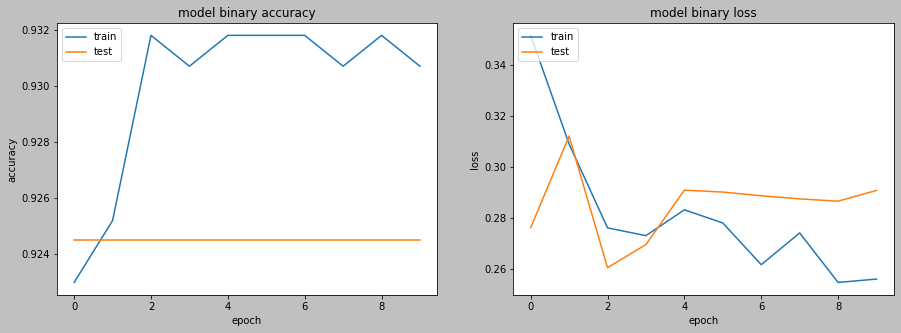

In [ ]:
#import matplotlib.pyplot as plt

def plot_los():
  fig = plt.figure(figsize=(15, 5)).patch.set_facecolor('silver')
  plt.subplot(121)

  plt.plot(hstry_1.history['binary_accuracy'])
  plt.plot(hstry_1.history['val_binary_accuracy'])
  plt.title('model binary accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  
  plt.subplot(122)
  plt.plot(hstry_1.history['loss'])
  plt.plot(hstry_1.history['val_loss'])

  plt.title('model binary loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()

plot_los()

**OBSERVATION**

1. from the loss curve, initially in epoch loss curve training loss is higher than validation loss that means underftting, which is quite evident as it is starting stage, but after epoch 3, validation loss is marginally
higher than training loss indicates model starts overfitting, but epoch 3 is the best balance we are looking for.

2. in binary accuracy plot training accuracy is increasing but test accuracy is constant because whaterever model learns it apllies on test set there is no new to learn from test data perspective, due to test set is limited with similar nature of condition (more damage), and repeatative similar images (i.e less variation in image data), this nature of graph occurs. 

3. try to overcome above limitation (point 2) with oversampling of inferior class, or using cars dataset, in version 2.0 of this case study.

In [ ]:
model_1.save('/content/gdrive/MyDrive/cs2/data/model1/model1_deepl.h5')

##transfer learning 

In [ ]:
from tensorflow.keras.callbacks import *

filepath = '/content/gdrive/MyDrive/cs2/data/model1/transfer_lrng/model1_transfer.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_binary_accuracy', verbose=1,save_best_only=True, mode='auto', save_freq='epoch')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=0.000001)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model_1_transfer_lrng.compile(loss='binary_crossentropy', optimizer = optimizer, metrics=[tf.keras.metrics.BinaryAccuracy()])

hstry_1_transfer_lrng = model_1_transfer_lrng.fit(img_train_gen,epochs=10, validation_data=img_cv_gen, batch_size=64, 
          callbacks=[checkpoint, reduce_lr])

Epoch 1/10
57/57 [==============================] - 32s 529ms/step - loss: 4.9261 - binary_accuracy: 0.6604 - val_loss: 1.5434 - val_binary_accuracy: 0.8975

Epoch 00001: val_binary_accuracy improved from -inf to 0.89748, saving model to /content/gdrive/MyDrive/cs2/data/model1/transfer_lrng/model1_transfer.hdf5
Epoch 2/10
57/57 [==============================] - 30s 532ms/step - loss: 2.4359 - binary_accuracy: 0.8344 - val_loss: 1.1515 - val_binary_accuracy: 0.9245

Epoch 00002: val_binary_accuracy improved from 0.89748 to 0.92449, saving model to /content/gdrive/MyDrive/cs2/data/model1/transfer_lrng/model1_transfer.hdf5
Epoch 3/10
57/57 [==============================] - 31s 536ms/step - loss: 1.7221 - binary_accuracy: 0.8831 - val_loss: 1.1515 - val_binary_accuracy: 0.9245

Epoch 00003: val_binary_accuracy did not improve from 0.92449
Epoch 4/10
57/57 [==============================] - 30s 521ms/step - loss: 1.3560 - binary_accuracy: 0.9069 - val_loss: 1.1515 - val_binary_accuracy: 0

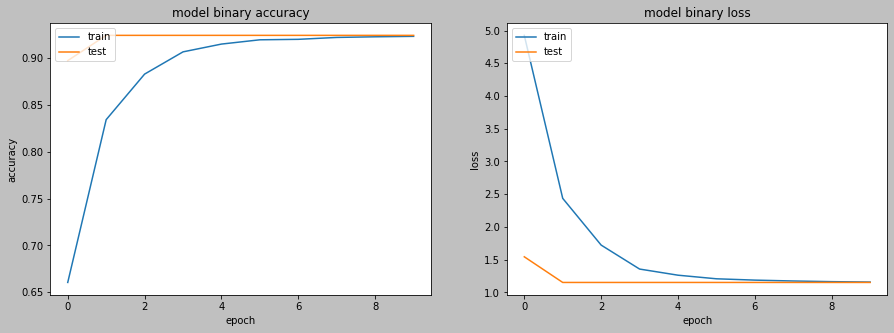

In [ ]:
#import matplotlib.pyplot as plt

def plot_los():
  fig = plt.figure(figsize=(15, 5)).patch.set_facecolor('silver')
  plt.subplot(121)

  plt.plot(hstry_1_transfer_lrng.history['binary_accuracy'])
  plt.plot(hstry_1_transfer_lrng.history['val_binary_accuracy'])
  plt.title('model binary accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  
  plt.subplot(122)
  plt.plot(hstry_1_transfer_lrng.history['loss'])
  plt.plot(hstry_1_transfer_lrng.history['val_loss'])

  plt.title('model binary loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()

plot_los()

**OBSERVATION**

1. from the loss curve, initially in epoch loss curve training loss is higher than validation loss that means underftting, which is quite evident as it is starting stage, but after epoch 6, validation loss is more or less equal to
training loss indicates model as it is the balance we are looking for.

2. in binary accuracy plot training accuracy is increasing but test accuracy is constant because whaterever model learns it apllies on test set there is no new to learn from test data perspective, due to test set is limited with similar nature of condition (more damage), and repeatative similar images (i.e less variation in image data), this nature of graph occurs. 

3. try to overcome above limitation (point 2) with oversampling of inferior class, or using cars dataset, in version 2.0 of this case study.

In [ ]:
model_1_transfer_lrng.save('/content/gdrive/MyDrive/cs2/data/model1/tranfer_lrng/model1_transfer_learning.h5')

In [ ]:
def get_embedd(model, generator, generator_1, generator_2, batch): 

    '''takes input of model : vgg-19/resnet/mobilenet/custom respectively in subsequent stages,
      generator, generator_1, generator_2 : image datagen for tain,test,cv
      batch   :  batch size (int)
      returns :  dataframe of train and test having transfer weights'''
  
    y_pred = model.predict(generator, batch)
    df = pd.DataFrame(y_pred)
    test_condition_model_1_tf = test_data_f.copy()
    test_condition_model_1_tf = pd.concat([test_condition_model_1, df], axis=1, join='inner')
    test_condition_model_1_tf.to_csv('/content/gdrive/MyDrive/cs2/data/model1/tranfer_lrng/test_model_1_transfer_learning.csv')

    y_pred_tr = model.predict(generator_1, batch)
    y_pred_cv = model.predict(generator_2, batch)
    kd0 = pd.concat([train, cv], axis=0)
    kd0.reset_index(inplace=True)
    print(kd0.shape)
    kd1 = pd.concat([pd.DataFrame(y_pred_tr), pd.DataFrame(y_pred_cv)], axis=0)
    kd1.reset_index(inplace=True)
    print(kd1.shape)
    kd_ = pd.concat([kd0,kd1], axis=1)
    kd_.to_csv('/content/gdrive/MyDrive/cs2/data/model1/tranfer_lrng/train_model_1_transfer_learning.csv')

    return test_condition_model_1_tf, kd_


In [ ]:
#_,train_transfer_wt = get_embedd(model_1_transfer_lrng, img_train_gen, img_cv_gen, 16, train=True)
test_transfer_wt,train_transfer_wt = get_embedd(model_1_transfer_lrng, img_test_gen, img_train_gen, img_cv_gen, 16)#, train=False)

(1399, 26)
(1399, 65)


#RESNET50


## simple

In [ ]:
base_resnet50 = tf.keras.applications.ResNet50(weights='imagenet',include_top=False, input_shape=(224,224,3))

In [ ]:
for layer in base_resnet50.layers[:175]:      ##for sake of checking
  layer.trainable = False
for i,layer in enumerate(base_resnet50.layers):
  print(i, layer.name, layer.trainable)                     


0 input_3 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [ ]:
model_2, model_2_transfer_lrng = final_model(base_resnet50)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
from tensorflow.keras.callbacks import *

filepath = '/content/gdrive/MyDrive/cs2/data/model2/img_only/model2_img_only.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_binary_accuracy', verbose=1,save_best_only=True, mode='auto', save_freq='epoch')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model_2.compile(loss='binary_crossentropy', optimizer = optimizer, metrics=[tf.keras.metrics.BinaryAccuracy()])

hstry_2 = model_2.fit(img_train_gen,epochs=10, validation_data=img_cv_gen, batch_size=8, 
          callbacks=[checkpoint, reduce_lr])

Epoch 1/10
57/57 [==============================] - 289s 4s/step - loss: 0.5679 - binary_accuracy: 0.8295 - val_loss: 0.3984 - val_binary_accuracy: 0.9245

Epoch 00001: val_binary_accuracy improved from -inf to 0.92449, saving model to /content/gdrive/MyDrive/cs2/data/model2/img_only/model2_img_only.hdf5
Epoch 2/10
57/57 [==============================] - 30s 533ms/step - loss: 0.3878 - binary_accuracy: 0.8746 - val_loss: 0.2665 - val_binary_accuracy: 0.9245

Epoch 00002: val_binary_accuracy did not improve from 0.92449
Epoch 3/10
57/57 [==============================] - 28s 496ms/step - loss: 0.3586 - binary_accuracy: 0.8922 - val_loss: 0.2716 - val_binary_accuracy: 0.9245

Epoch 00003: val_binary_accuracy did not improve from 0.92449
Epoch 4/10
57/57 [==============================] - 28s 500ms/step - loss: 0.3143 - binary_accuracy: 0.9131 - val_loss: 0.3165 - val_binary_accuracy: 0.9245

Epoch 00004: val_binary_accuracy did not improve from 0.92449
Epoch 5/10
57/57 [================

In [ ]:
score = model_2.evaluate(img_cv_gen, verbose=1, batch_size=64)

31/31 [==============================] - 10s 315ms/step - loss: 0.2709 - binary_accuracy: 0.9245


In [ ]:
y_pred_0 = model_2.predict(img_cv_gen, batch_size=64)
preds_0 = (model_2.predict(img_cv_gen)>0.5).astype("int32")
metrics(cv['Condition'], preds_0)

Recall micro      :  0.9244897959183673
Precision micro   :  0.9244897959183673
Fl score micro    :  0.9244897959183674


**OBSERVATION**

1. having only that class which is damage, as it is only we have predict the details about.

In [ ]:
test_condition_model_2 = test_pred_cond(model_2, img_test_gen, test_data_f)
test_condition_model_2.to_csv('/content/gdrive/MyDrive/cs2/data/model2/img_only/test_condition_model_2.csv')

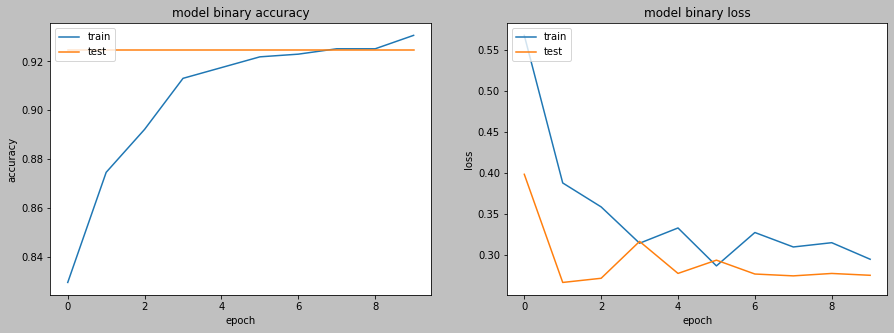

In [ ]:
#import matplotlib.pyplot as plt

def plot_los():
  fig = plt.figure(figsize=(15, 5)).patch.set_facecolor('silver')
  plt.subplot(121)

  plt.plot(hstry_2.history['binary_accuracy'])
  plt.plot(hstry_2.history['val_binary_accuracy'])
  plt.title('model binary accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  
  plt.subplot(122)
  plt.plot(hstry_2.history['loss'])
  plt.plot(hstry_2.history['val_loss'])

  plt.title('model binary loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()

plot_los()

**OBSERVATION**

1. from the loss curve, initially in epoch loss curve training loss is higher than validation loss that means underftting, which is quite evident as it is starting stage, but at epoch 3,5, validation loss (here test loss) is more or less equal to training loss indicates model as it is the balance we are looking for.

2. in binary accuracy plot training accuracy is increasing but test accuracy is constant because whaterever model learns it apllies on test set there is no new to learn from test data perspective, due to test set is limited with similar nature of condition (more damage), and repeatative similar images (i.e less variation in image data), this nature of graph occurs. 

3. try to overcome above limitation (point 2) with oversampling of inferior class, or using cars dataset, in version 2.0 of this case study.

In [ ]:
model_2.save('/content/gdrive/MyDrive/cs2/data/model2/model2_deepl.h5')

##transfer learning 

In [ ]:
from tensorflow.keras.callbacks import *

filepath = '/content/gdrive/MyDrive/cs2/data/model2/transfer_lrng/model2_transfer.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_binary_accuracy', verbose=1,save_best_only=True, mode='auto', save_freq='epoch')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=0.000001)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model_2_transfer_lrng.compile(loss='binary_crossentropy', optimizer = optimizer, metrics=[tf.keras.metrics.BinaryAccuracy()])

hstry_2_transfer_lrng = model_2_transfer_lrng.fit(img_train_gen,epochs=10, validation_data=img_cv_gen, batch_size=16, 
          callbacks=[checkpoint, reduce_lr])

Epoch 1/10
57/57 [==============================] - 35s 548ms/step - loss: 5.8424 - binary_accuracy: 0.5766 - val_loss: 4.4181 - val_binary_accuracy: 0.6992

Epoch 00001: val_binary_accuracy improved from -inf to 0.69920, saving model to /content/gdrive/MyDrive/cs2/data/model2/transfer_lrng/model2_transfer.hdf5
Epoch 2/10
57/57 [==============================] - 31s 536ms/step - loss: 3.6260 - binary_accuracy: 0.7117 - val_loss: 2.3804 - val_binary_accuracy: 0.8449

Epoch 00002: val_binary_accuracy improved from 0.69920 to 0.84490, saving model to /content/gdrive/MyDrive/cs2/data/model2/transfer_lrng/model2_transfer.hdf5
Epoch 3/10
57/57 [==============================] - 31s 536ms/step - loss: 2.6238 - binary_accuracy: 0.7563 - val_loss: 1.5611 - val_binary_accuracy: 0.8980

Epoch 00003: val_binary_accuracy improved from 0.84490 to 0.89796, saving model to /content/gdrive/MyDrive/cs2/data/model2/transfer_lrng/model2_transfer.hdf5
Epoch 4/10
57/57 [==============================] - 30s

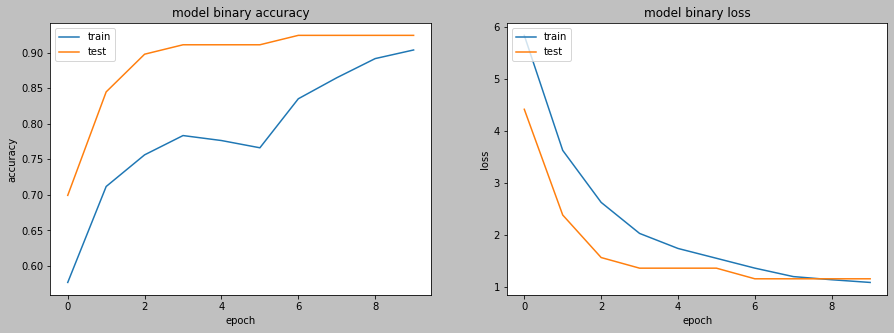

In [ ]:
#import matplotlib.pyplot as plt

def plot_los():
  fig = plt.figure(figsize=(15, 5)).patch.set_facecolor('silver')
  plt.subplot(121)

  plt.plot(hstry_2_transfer_lrng.history['binary_accuracy'])
  plt.plot(hstry_2_transfer_lrng.history['val_binary_accuracy'])
  plt.title('model binary accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  
  plt.subplot(122)
  plt.plot(hstry_2_transfer_lrng.history['loss'])
  plt.plot(hstry_2_transfer_lrng.history['val_loss'])

  plt.title('model binary loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()

plot_los()

**OBSERVATION**

1. from the loss curve, initially in epoch loss curve training loss is higher than validation loss that means underftting, which is quite evident as it is starting stage, but after epoch 7, validation loss is slightly more than training loss indicates model will overfit after this, at epoch 8 as it is the balance we are looking for.

2. in binary accuracy plot training accuracy is increasing, test accuracy is also increasing whatever model is learning able to apply well on test data, it can be more iterated for more convergence.


In [ ]:
model_2_transfer_lrng.save('/content/gdrive/MyDrive/cs2/data/model2/transfer_lrng/model2_transfer_learning.h5')

In [ ]:
def get_embedd(model, generator, generator_1, generator_2, batch): 
    
    '''takes input of model : vgg-19/resnet/mobilenet/custom respectively in subsequent stages,
      generator, generator_1, generator_2 : image datagen for tain,test,cv
      batch   :  batch size (int)
      returns :  dataframe of train and test having transfer weights'''

    y_pred = model.predict(generator, batch)
    df = pd.DataFrame(y_pred)
    test_condition_model_1_tf = test_data_f.copy()
    test_condition_model_1_tf = pd.concat([test_condition_model_2, df], axis=1, join='inner')
    test_condition_model_1_tf.to_csv('/content/gdrive/MyDrive/cs2/data/model2/transfer_lrng/test_model_2_transfer_learning.csv')

    y_pred_tr = model.predict(generator_1, batch)
    y_pred_cv = model.predict(generator_2, batch)
    kd0 = pd.concat([train, cv], axis=0)
    kd0.reset_index(inplace=True)
    print(kd0.shape)
    kd1 = pd.concat([pd.DataFrame(y_pred_tr), pd.DataFrame(y_pred_cv)], axis=0)
    kd1.reset_index(inplace=True)
    print(kd1.shape)
    kd_ = pd.concat([kd0,kd1], axis=1)
    kd_.to_csv('/content/gdrive/MyDrive/cs2/data/model2/transfer_lrng/train_model_2_transfer_learning.csv')

    return test_condition_model_1_tf, kd_


In [ ]:
#_,train_transfer_wt = get_embedd(model_1_transfer_lrng, img_train_gen, img_cv_gen, 16, train=True)
test_transfer_wt, train_transfer_wt = get_embedd(model_2_transfer_lrng, img_test_gen, img_train_gen, img_cv_gen, 16)#, train=False)

(1399, 26)
(1399, 65)


# Mobile Net

In [ ]:
base_mobilenet = tf.keras.applications.MobileNet(weights='imagenet',include_top=False, input_shape=(224,224,3))

In [ ]:
for layer in base_mobilenet.layers[:86]:      ##for sake of checking
  layer.trainable = False
for i,layer in enumerate(base_mobilenet.layers):
  print(i, layer.name, layer.trainable)                     


0 input_6 False
1 conv1 False
2 conv1_bn False
3 conv1_relu False
4 conv_dw_1 False
5 conv_dw_1_bn False
6 conv_dw_1_relu False
7 conv_pw_1 False
8 conv_pw_1_bn False
9 conv_pw_1_relu False
10 conv_pad_2 False
11 conv_dw_2 False
12 conv_dw_2_bn False
13 conv_dw_2_relu False
14 conv_pw_2 False
15 conv_pw_2_bn False
16 conv_pw_2_relu False
17 conv_dw_3 False
18 conv_dw_3_bn False
19 conv_dw_3_relu False
20 conv_pw_3 False
21 conv_pw_3_bn False
22 conv_pw_3_relu False
23 conv_pad_4 False
24 conv_dw_4 False
25 conv_dw_4_bn False
26 conv_dw_4_relu False
27 conv_pw_4 False
28 conv_pw_4_bn False
29 conv_pw_4_relu False
30 conv_dw_5 False
31 conv_dw_5_bn False
32 conv_dw_5_relu False
33 conv_pw_5 False
34 conv_pw_5_bn False
35 conv_pw_5_relu False
36 conv_pad_6 False
37 conv_dw_6 False
38 conv_dw_6_bn False
39 conv_dw_6_relu False
40 conv_pw_6 False
41 conv_pw_6_bn False
42 conv_pw_6_relu False
43 conv_dw_7 False
44 conv_dw_7_bn False
45 conv_dw_7_relu False
46 conv_pw_7 False
47 conv_pw_7_bn 

In [ ]:
model_3, model_3_transfer_lrng = final_model(base_mobilenet)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0   

In [ ]:
from tensorflow.keras.callbacks import *

filepath = '/content/gdrive/MyDrive/cs2/data/model3/img_only/model3_img_only.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_binary_accuracy', verbose=1,save_best_only=True, mode='auto', save_freq='epoch')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model_3.compile(loss='binary_crossentropy', optimizer = optimizer, metrics=[tf.keras.metrics.BinaryAccuracy()])

hstry_3 = model_3.fit(img_train_gen,epochs=10, validation_data=img_cv_gen, batch_size=8, 
          callbacks=[checkpoint, reduce_lr])

Epoch 1/10
57/57 [==============================] - 30s 490ms/step - loss: 0.6635 - binary_accuracy: 0.9131 - val_loss: 0.2824 - val_binary_accuracy: 0.9245

Epoch 00001: val_binary_accuracy improved from -inf to 0.92449, saving model to /content/gdrive/MyDrive/cs2/data/model3/img_only/model3_img_only.hdf5
Epoch 2/10
57/57 [==============================] - 27s 478ms/step - loss: 0.4529 - binary_accuracy: 0.8966 - val_loss: 0.2970 - val_binary_accuracy: 0.9245

Epoch 00002: val_binary_accuracy did not improve from 0.92449
Epoch 3/10
57/57 [==============================] - 27s 473ms/step - loss: 0.4053 - binary_accuracy: 0.9065 - val_loss: 0.3060 - val_binary_accuracy: 0.9245

Epoch 00003: val_binary_accuracy did not improve from 0.92449
Epoch 4/10
57/57 [==============================] - 27s 469ms/step - loss: 0.3247 - binary_accuracy: 0.9164 - val_loss: 0.2778 - val_binary_accuracy: 0.9245

Epoch 00004: val_binary_accuracy did not improve from 0.92449
Epoch 5/10
57/57 [==============

In [ ]:
score = model_3.evaluate(img_cv_gen, verbose=1, batch_size=64)

31/31 [==============================] - 9s 289ms/step - loss: 0.2599 - binary_accuracy: 0.9245


In [ ]:
y_pred_0 = model_3.predict(img_cv_gen, batch_size=64)
preds_0 = (model_3.predict(img_cv_gen)>0.5).astype("int32")
metrics(cv['Condition'], preds_0)

Recall micro      :  0.9183673469387755
Precision micro   :  0.9183673469387755
Fl score micro    :  0.9183673469387755


**OBSERVATION**

1. having only that class which is damage, as it is only we have predict the details about.

In [ ]:
test_condition_model_3 = test_pred_cond(model_3, img_test_gen, test_data_f)
test_condition_model_3.to_csv('/content/gdrive/MyDrive/cs2/data/model3/img_only/test_condition_model_3.csv')

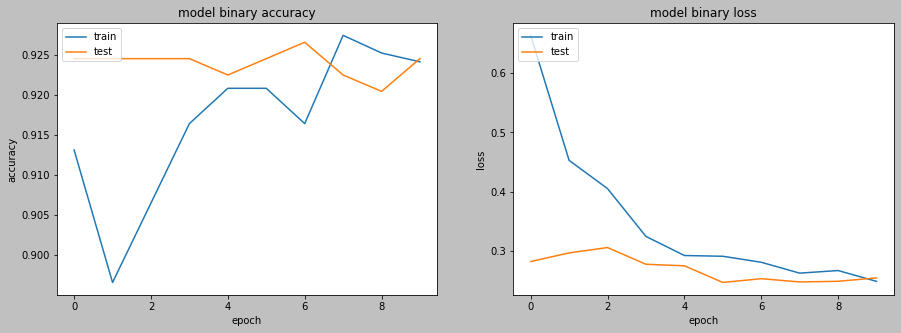

In [ ]:
#import matplotlib.pyplot as plt

def plot_los():
  fig = plt.figure(figsize=(15, 5)).patch.set_facecolor('silver')
  plt.subplot(121)

  plt.plot(hstry_3.history['binary_accuracy'])
  plt.plot(hstry_3.history['val_binary_accuracy'])
  plt.title('model binary accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  
  plt.subplot(122)
  plt.plot(hstry_3.history['loss'])
  plt.plot(hstry_3.history['val_loss'])

  plt.title('model binary loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()

plot_los()

**OBSERVATION**

1. from the loss curve, initially in epoch loss curve training loss is higher than validation loss that means underftting, which is quite evident as it is starting stage, but at epoch 9, validation loss (here test loss) is more or less equal to training loss indicates model as it is the balance we are looking for, after epoch 9 it may start overfitting.

2. in binary accuracy plot training accuracy is increasing, test loss have hapazard movement, may be because whatever model learing not able to apply in that epoch, more epoch require to have definate say, moreover at epoch 9, we see balance train and test accuracy.



In [ ]:
model_3.save('/content/gdrive/MyDrive/cs2/data/model3/model3_deepl.h5')

##transfer learning 

In [ ]:
from tensorflow.keras.callbacks import *

filepath = '/content/gdrive/MyDrive/cs2/data/model3/transfer_lrng/model3_transfer.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_binary_accuracy', verbose=1,save_best_only=True, mode='auto', save_freq='epoch')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=0.000001)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model_3_transfer_lrng.compile(loss='binary_crossentropy', optimizer = optimizer, metrics=[tf.keras.metrics.BinaryAccuracy()])

hstry_3_transfer_lrng = model_3_transfer_lrng.fit(img_train_gen,epochs=10, validation_data=img_cv_gen, batch_size=16, 
          callbacks=[checkpoint, reduce_lr])

Epoch 1/10
57/57 [==============================] - 29s 477ms/step - loss: 5.3835 - binary_accuracy: 0.6433 - val_loss: 2.6366 - val_binary_accuracy: 0.8266

Epoch 00001: val_binary_accuracy improved from -inf to 0.82659, saving model to /content/gdrive/MyDrive/cs2/data/model3/transfer_lrng/model3_transfer.hdf5
Epoch 2/10
57/57 [==============================] - 27s 476ms/step - loss: 3.5558 - binary_accuracy: 0.7663 - val_loss: 1.5945 - val_binary_accuracy: 0.8950

Epoch 00002: val_binary_accuracy improved from 0.82659 to 0.89503, saving model to /content/gdrive/MyDrive/cs2/data/model3/transfer_lrng/model3_transfer.hdf5
Epoch 3/10
57/57 [==============================] - 27s 478ms/step - loss: 2.5781 - binary_accuracy: 0.8307 - val_loss: 1.3563 - val_binary_accuracy: 0.9112

Epoch 00003: val_binary_accuracy improved from 0.89503 to 0.91122, saving model to /content/gdrive/MyDrive/cs2/data/model3/transfer_lrng/model3_transfer.hdf5
Epoch 4/10
57/57 [==============================] - 27s

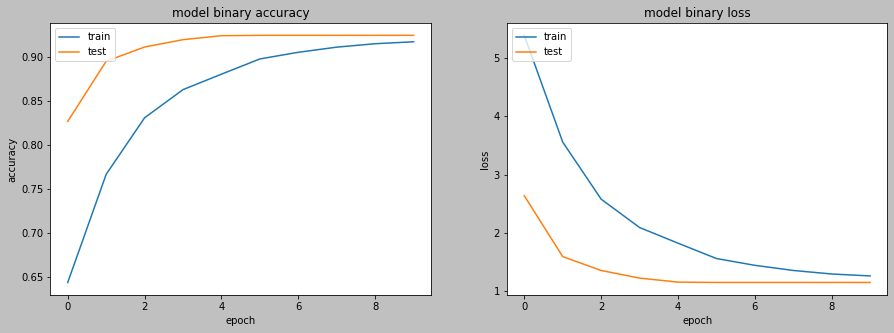

In [ ]:
#import matplotlib.pyplot as plt

def plot_los():
  fig = plt.figure(figsize=(15, 5)).patch.set_facecolor('silver')
  plt.subplot(121)

  plt.plot(hstry_3_transfer_lrng.history['binary_accuracy'])
  plt.plot(hstry_3_transfer_lrng.history['val_binary_accuracy'])
  plt.title('model binary accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  
  plt.subplot(122)
  plt.plot(hstry_3_transfer_lrng.history['loss'])
  plt.plot(hstry_3_transfer_lrng.history['val_loss'])

  plt.title('model binary loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()

plot_los()

**OBSERVATION**

1. from the loss curve, initially in epoch loss curve training loss is higher than validation loss that means underftting, which is quite evident as it is starting stage, but after epoch 9, validation loss will be converging with  training loss indicates at epoch 9 or after as it is the balance we are looking for.

2. in binary accuracy plot training accuracy is increasing, test accuracy is also increasing whatever model is learning able to apply well on test data, it can be more iterated for more convergence.

In [ ]:
model_3_transfer_lrng.save('/content/gdrive/MyDrive/cs2/data/model3/transfer_lrng/model3_transfer_learning.h5')

In [ ]:
def get_embedd(model, generator, generator_1, generator_2, batch): 
    
    '''takes input of model : vgg-19/resnet/mobilenet/custom respectively in subsequent stages,
      generator, generator_1, generator_2 : image datagen for tain,test,cv
      batch   :  batch size (int)
      returns :  dataframe of train and test having transfer weights'''


    y_pred = model.predict(generator, batch)
    df = pd.DataFrame(y_pred)
    test_condition_model_1_tf = test_data_f.copy()
    test_condition_model_1_tf = pd.concat([test_condition_model_3, df], axis=1, join='inner')
    test_condition_model_1_tf.to_csv('/content/gdrive/MyDrive/cs2/data/model3/transfer_lrng/test_model_3_transfer_learning.csv')

    y_pred_tr = model.predict(generator_1, batch)
    y_pred_cv = model.predict(generator_2, batch)
    kd0 = pd.concat([train, cv], axis=0)
    kd0.reset_index(inplace=True)
    print(kd0.shape)
    kd1 = pd.concat([pd.DataFrame(y_pred_tr), pd.DataFrame(y_pred_cv)], axis=0)
    kd1.reset_index(inplace=True)
    print(kd1.shape)
    kd_ = pd.concat([kd0,kd1], axis=1)
    kd_.to_csv('/content/gdrive/MyDrive/cs2/data/model3/transfer_lrng/train_model_3_transfer_learning.csv')

    return test_condition_model_1_tf, kd_


In [ ]:
#_,train_transfer_wt = get_embedd(model_1_transfer_lrng, img_train_gen, img_cv_gen, 16, train=True)
test_transfer_wt, train_transfer_wt = get_embedd(model_3_transfer_lrng, img_test_gen, img_train_gen, img_cv_gen, 16)#, train=False)

(1399, 26)
(1399, 65)


#custom model

In [ ]:
#structure taken from https://www.kaggle.com/ankitachoudhury01/image-classification-and-xgboost-for-beginners

def custom_model():
  input = Input(shape=(224,224,3))
  x = Conv2D(filters=16, kernel_size=(3,3),activation='relu')(input)
  x = Conv2D(filters=16, kernel_size=(3,3),activation='relu')(x)
  x = Conv2D(filters=16, kernel_size=(3,3),activation='relu')(x)
  x = MaxPooling2D(pool_size=(2,2))(x)

  x = Conv2D(filters=64, kernel_size=(3,3),activation='relu')(x)
  x = Conv2D(filters=64, kernel_size=(3,3),activation='relu')(x)
  x = Conv2D(filters=64, kernel_size=(3,3),activation='relu')(x)
  x = MaxPooling2D(pool_size=(2,2))(x)

  x = Conv2D(filters=128, kernel_size=(3,3),activation='relu')(x)
  x = Conv2D(filters=128, kernel_size=(3,3),activation='relu')(x)
  x = Conv2D(filters=128, kernel_size=(3,3),activation='relu')(x)
  x = MaxPooling2D(pool_size=(2,2))(x)

  x = Conv2D(filters=256, kernel_size=(3,3),activation='relu')(x)
  x = Conv2D(filters=256, kernel_size=(3,3),activation='relu')(x)
  x = Conv2D(filters=256, kernel_size=(3,3),activation='relu')(x)
  x = MaxPooling2D(pool_size=(2,2))(x)


  x = Conv2D(filters=512, kernel_size=(3,3),activation='relu')(x)
  x = Conv2D(filters=512, kernel_size=(3,3),activation='relu')(x)
  x = Conv2D(filters=512, kernel_size=(3,3),activation='relu')(x)
  x = MaxPooling2D(pool_size=(2,2))(x)


  x = Conv2D(filters=1024, kernel_size=(3,3),activation='relu',padding = 'same')(x)
  x = MaxPooling2D(pool_size=(2,2), padding = "same")(x)


  flat = Flatten()(x)    ### input layer
  fc1 = Dense(216, activation='relu', kernel_initializer=tf.keras.initializers.glorot_normal(seed=0))(flat)
  drop1 = Dropout(0.5)(fc1)
  #fc2 = Dense(512, activation='relu', kernel_initializer=tf.keras.initializers.glorot_normal(seed=0))(drop1)
  fc3 = Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.glorot_normal(seed=0))(drop1)
  drop2 = Dropout(0.5)(fc3)
  fc4 = Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.glorot_normal(seed=0))(drop2)
  out = Dense(1, activation='sigmoid')(fc4)

  mdl_1 = Model(inputs=[input], outputs=[out])
  mdl_1_transfer_lrng = Model(inputs=[input], outputs=[fc4])
  mdl_1.summary()
  return mdl_1, mdl_1_transfer_lrng



In [ ]:
model_4, model_4_transfer_lrng = custom_model()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 222, 222, 16)      448       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 220, 220, 16)      2320      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 218, 218, 16)      2320      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 109, 109, 16)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 107, 107, 64)      9280      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 105, 105, 64)      3692

In [ ]:
from tensorflow.keras.callbacks import *

filepath = '/content/gdrive/MyDrive/cs2/data/model4/img_only/model4_img_only.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_binary_accuracy', verbose=1,save_best_only=True, mode='auto', save_freq='epoch')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model_4.compile(loss='binary_crossentropy', optimizer = optimizer, metrics=[tf.keras.metrics.BinaryAccuracy()])

hstry_4 = model_4.fit(img_train_gen,epochs=10, validation_data=img_cv_gen, batch_size=8, 
          callbacks=[checkpoint, reduce_lr])

Epoch 1/10
57/57 [==============================] - 40s 592ms/step - loss: 0.4379 - binary_accuracy: 0.9219 - val_loss: 0.3279 - val_binary_accuracy: 0.9245

Epoch 00001: val_binary_accuracy improved from -inf to 0.92449, saving model to /content/gdrive/MyDrive/cs2/data/model4/img_only/model4_img_only.hdf5
Epoch 2/10
57/57 [==============================] - 30s 517ms/step - loss: 0.2932 - binary_accuracy: 0.9318 - val_loss: 0.2799 - val_binary_accuracy: 0.9245

Epoch 00002: val_binary_accuracy did not improve from 0.92449
Epoch 3/10
57/57 [==============================] - 29s 510ms/step - loss: 0.3283 - binary_accuracy: 0.9318 - val_loss: 0.3705 - val_binary_accuracy: 0.9245

Epoch 00003: val_binary_accuracy did not improve from 0.92449
Epoch 4/10
57/57 [==============================] - 29s 510ms/step - loss: 0.2830 - binary_accuracy: 0.9318 - val_loss: 0.2813 - val_binary_accuracy: 0.9245

Epoch 00004: val_binary_accuracy did not improve from 0.92449
Epoch 5/10
57/57 [==============

In [ ]:
score = model_4.evaluate(img_cv_gen, verbose=1, batch_size=64)

31/31 [==============================] - 9s 293ms/step - loss: 0.2753 - binary_accuracy: 0.9245


In [ ]:
y_pred_0 = model_4.predict(img_cv_gen, batch_size=64)
preds_0 = (model_4.predict(img_cv_gen)>0.5).astype("int32")
metrics(cv['Condition'], preds_0)

Recall micro      :  0.9244897959183673
Precision micro   :  0.9244897959183673
Fl score micro    :  0.9244897959183674


In [ ]:
test_condition_model_4 = test_pred_cond(model_4, img_test_gen, test_data_f)
test_condition_model_4.to_csv('/content/gdrive/MyDrive/cs2/data/model4/img_only/test_condition_model_4.csv')

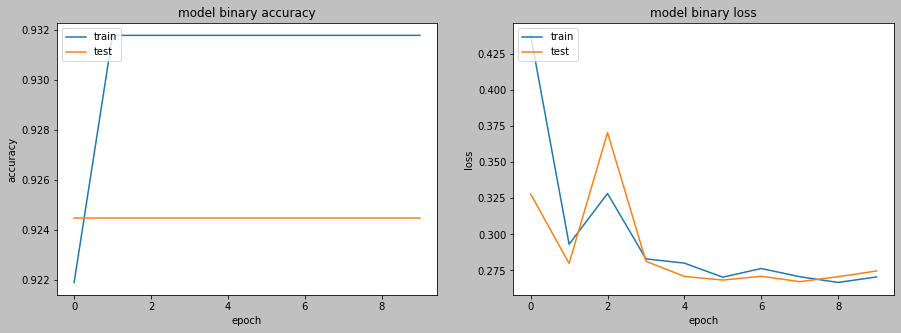

In [ ]:
#import matplotlib.pyplot as plt

def plot_los():
  fig = plt.figure(figsize=(15, 5)).patch.set_facecolor('silver')
  plt.subplot(121)

  plt.plot(hstry_4.history['binary_accuracy'])
  plt.plot(hstry_4.history['val_binary_accuracy'])
  plt.title('model binary accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  
  plt.subplot(122)
  plt.plot(hstry_4.history['loss'])
  plt.plot(hstry_4.history['val_loss'])

  plt.title('model binary loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()

plot_los()

**OBSERVATION**

1. from the loss curve, initially in epoch loss curve training loss is higher than validation loss that means underftting, which is quite evident as it is starting stage, but at epoch 1-3 and after 7, validation loss (here test loss) is more than training loss indicates model is overfitting, at epoch 3 or 7, strikes the balance we are looking for.

2. in binary accuracy plot training accuracy is increasing but test accuracy is constant because whaterever model learns it apllies on test set there is no new to learn from test data perspective, due to test set is limited with similar nature of condition (more damage), and repeatative similar images (i.e less variation in image data), this nature of graph occurs. 

3. try to overcome above limitation (point 2) with oversampling of inferior class, or using cars dataset, in version 2.0 of this case study.

In [ ]:
model_4.save('/content/gdrive/MyDrive/cs2/data/model4/model4_deepl.h5')

##transfer learning 

In [ ]:
from tensorflow.keras.callbacks import *

filepath = '/content/gdrive/MyDrive/cs2/data/model4/transfer_lrng/model4_transfer.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_binary_accuracy', verbose=1,save_best_only=True, mode='auto', save_freq='epoch')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=0.000001)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model_4_transfer_lrng.compile(loss='binary_crossentropy', optimizer = optimizer, metrics=[tf.keras.metrics.BinaryAccuracy()])

hstry_4_transfer_lrng = model_4_transfer_lrng.fit(img_train_gen,epochs=10, validation_data=img_cv_gen, batch_size=16, 
          callbacks=[checkpoint, reduce_lr])

Epoch 1/10
57/57 [==============================] - 32s 537ms/step - loss: 5.7883 - binary_accuracy: 0.6207 - val_loss: 5.0431 - val_binary_accuracy: 0.6724

Epoch 00001: val_binary_accuracy improved from -inf to 0.67245, saving model to /content/gdrive/MyDrive/cs2/data/model4/transfer_lrng/model4_transfer.hdf5
Epoch 2/10
57/57 [==============================] - 30s 530ms/step - loss: 5.6638 - binary_accuracy: 0.6323 - val_loss: 5.0426 - val_binary_accuracy: 0.6725

Epoch 00002: val_binary_accuracy improved from 0.67245 to 0.67248, saving model to /content/gdrive/MyDrive/cs2/data/model4/transfer_lrng/model4_transfer.hdf5
Epoch 3/10
57/57 [==============================] - 30s 534ms/step - loss: 5.6365 - binary_accuracy: 0.6341 - val_loss: 5.0421 - val_binary_accuracy: 0.6725

Epoch 00003: val_binary_accuracy improved from 0.67248 to 0.67251, saving model to /content/gdrive/MyDrive/cs2/data/model4/transfer_lrng/model4_transfer.hdf5
Epoch 4/10
57/57 [==============================] - 30s

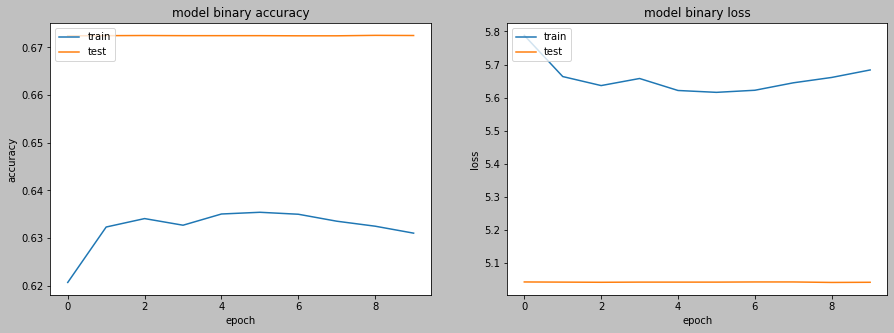

In [ ]:
#import matplotlib.pyplot as plt

def plot_los():
  fig = plt.figure(figsize=(15, 5)).patch.set_facecolor('silver')
  plt.subplot(121)

  plt.plot(hstry_4_transfer_lrng.history['binary_accuracy'])
  plt.plot(hstry_4_transfer_lrng.history['val_binary_accuracy'])
  plt.title('model binary accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  
  plt.subplot(122)
  plt.plot(hstry_4_transfer_lrng.history['loss'])
  plt.plot(hstry_4_transfer_lrng.history['val_loss'])

  plt.title('model binary loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()

plot_los()

**OBSERVATION**

1. from the loss curve, initially in epoch loss curve training loss is higher than validation loss that means underftting, which is quite evident as it is starting stage, that to is too large in quantam, no sign of convergence, underfit because less layers in model (less depth) in custom architecture as compare to other models (transfer learning models) therefore not able to learn the appropriate features , it has to be ignored while considering.



In [ ]:
model_4_transfer_lrng.save('/content/gdrive/MyDrive/cs2/data/model4/transfer_lrng/model4_transfer_learning.h5')

In [ ]:
def get_embedd(model, generator, generator_1, generator_2, batch): 

    '''takes input of model : vgg-19/resnet/mobilenet/custom respectively in subsequent stages,
      generator, generator_1, generator_2 : image datagen for tain,test,cv
      batch   :  batch size (int)
      returns :  dataframe of train and test having transfer weights'''
 
    y_pred = model.predict(generator, batch)
    df = pd.DataFrame(y_pred)
    test_condition_model_1_tf = test_data_f.copy()
    test_condition_model_1_tf = pd.concat([test_condition_model_3, df], axis=1, join='inner')
    test_condition_model_1_tf.to_csv('/content/gdrive/MyDrive/cs2/data/model4/transfer_lrng/test_model_4_transfer_learning.csv')
 
    y_pred_tr = model.predict(generator_1, batch)
    y_pred_cv = model.predict(generator_2, batch)
    kd0 = pd.concat([train, cv], axis=0)
    kd0.reset_index(inplace=True)
    print(kd0.shape)
    kd1 = pd.concat([pd.DataFrame(y_pred_tr), pd.DataFrame(y_pred_cv)], axis=0)
    kd1.reset_index(inplace=True)
    print(kd1.shape)
    kd_ = pd.concat([kd0,kd1], axis=1)
    kd_.to_csv('/content/gdrive/MyDrive/cs2/data/model4/transfer_lrng/train_model_4_transfer_learning.csv')

    return test_condition_model_1_tf, kd_


In [ ]:
#_,train_transfer_wt = get_embedd(model_1_transfer_lrng, img_train_gen, img_cv_gen, 16, train=True)
test_transfer_wt, train_transfer_wt = get_embedd(model_4_transfer_lrng, img_test_gen, img_train_gen, img_cv_gen, 16)

(1399, 26)
(1399, 65)
